## Classifying MNIST handwriting digits with Multi Layer Perceptron(MLP)

* In this session, we will create a fully connected MLP with one hidden layer, train and evaluate the network on the MNIST dataset. 
* The MNIST dataset is small enough that we can use a simple MLP for training( (The MNIST images are relatively small)

## What does our planned MLP looks like? Draw the diagram 

* How many inputs?
* How many hidden layers?
* How many neurons in the hidden layers?
* How many neurons in the output layer?
* What about activation functions?


## The Main Steps

Generally, the main steps for building a Deep Learning Neural Network are as follows. 

1. Import libraries, seed
2. Set data preprocessing (transform), download dataset, split train and test 
3. Set Dataloaders 
4. Define the model class
5. Set loss function, optimizer and learning rate
6. Training : Load the data
7. Training : Zero the parameter gradients
8. Training : Compute fwd
9. Training : Compute loss
10. Training : Compute backward,set optimizer(update weights)
10. Evaluation of trained model on test dataset

## 1. Import libraries, seeding random for reproducibility

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np 
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
% matplotlib inline

seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True  
torch.backends.cudnn.benchmark = False #for a small dataset, simple network , this is not really needed
np.random.seed(seed)


UsageError: Line magic function `%` not found.


## 2. Download the MNIST dataset and Data pre-processing

* Each PIL image is converted to a PyTorch tensor using transforms.ToTensor()
* The 28*28 image data is flattened into a vector using lambda which is a customized transformation. Here lambda returns a new view of the input tensor which is the product of the input tensor's dimension. 

* We are also splitting the MNIST dataset into training and test dataset








In [2]:

transformCustom = transforms.Compose([
                                transforms.ToTensor(), #this convert to tensor
                                transforms.Lambda(lambda x:x.view(-1))  #this flatten 28*28 into a 784 vector for each image
])


train = datasets.MNIST(root='.',train=True,transform=transformCustom, download=True)
test = datasets.MNIST(root='.', train=False, transform=transformCustom,download=True)

print(len(train.data))


60000


## 3. DataLoaders

* Previously like in the perceptron assignment, we passed data manually. Depends on the implementation, for each iteration sometimes we pass one row of data, or one mini batch of data, or one whole batch of data. And for the case of Stochastic Gradient Descent, we need to randomly shuffle the dataset or randomly pick one sample from the dataset i.e we have to do it manually

* In PyTorch, we can use DataLoader class that automatically pass the batches of data fetched from a Dataset object. We can also set if we want the DataLoader to shuffle the data and the size of each batch of data.

* Each batch is a tuple containing the images in the first element and the labels in the second

In [3]:
#Set DataLoader
batchSize = 128  # Rule of thumb is to set to the power of 2. In this case 2^7
train_loader = DataLoader(train, batch_size=batchSize,shuffle=True)
test_loader = DataLoader(test,batch_size=batchSize, shuffle=False) # no need to shuffle test data

## Task:

What is the shape of the train data and train label?

How many batches are there? Is the size for each batch the same ? 

Do the same for test data (test_loader)

In [4]:
print(f'There are {len(train_loader)} batches in train_loader')
print(f'There are {len(test_loader)} batches in test_loader')
for x, y in train_loader:
    print(x, y)
    break

There are 469 batches in train_loader
There are 79 batches in test_loader
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([7, 6, 1, 6, 5, 8, 8, 6, 6, 3, 2, 9, 8, 6, 9, 2, 0, 1, 3, 9, 5, 6, 1, 0,
        8, 8, 8, 9, 7, 1, 1, 8, 0, 3, 8, 2, 7, 3, 7, 7, 6, 5, 4, 7, 7, 0, 2, 5,
        7, 4, 1, 3, 7, 7, 8, 2, 8, 5, 2, 0, 5, 8, 2, 4, 6, 8, 0, 1, 3, 8, 9, 6,
        2, 5, 3, 0, 9, 1, 7, 3, 0, 1, 8, 2, 2, 9, 0, 6, 0, 0, 1, 3, 4, 4, 1, 9,
        2, 3, 6, 4, 0, 0, 3, 5, 8, 9, 6, 3, 6, 1, 6, 7, 1, 7, 1, 8, 4, 5, 8, 6,
        3, 8, 6, 3, 9, 7, 8, 0])


## Define the Neural Net model/class (MLP with one hidden layer, fully connected)

* Define our model in a class that extends nn.Module. 
* nn.Module subclasses must do a minimum of one thing: implement the forward method which takes a batch of data and performs the forward-pass. 

* PyTorch's autograd system will take care of computing the gradients of the forward pass for us. In the code below we'll also make use of the constructor of our model to instantiate the hidden and output layers.


* The nn.Module class defines a instance variable called `training` that is set to True when the model is being trained and False when it is being evaluated after being trained. 

* In our model definition we've used a softmax activation function on the output layer to turn the outputs into probability-like values, but have only set this to be enabled when we are not training the model. We've done this because we will use PyTorch's implementation of Cross Entropy Loss (nn.CrossEntropyLoss) during training which **implicitly** adds a softmax before a logarithmic loss.

* In our case the softmax isn't actually necessary for model evaluation if we're only interested in the most likely class; the logits (unscaled log probabilities) provided by the final fully connected layer before the softmax can be used directly as the largest logit will correspond to the most likely class.


In [5]:
class MLP(nn.Module):
  #for this excercise, input layer size = hidden layer size = 764, num_classes = 10
  def __init__(self,input_size, hidden_size,num_classes):
    super(MLP,self).__init__()

    self.layer1 = nn.Linear(input_size,hidden_size) 
    self.layer2 = nn.Linear(hidden_size,num_classes)

  def forward(self,x): 

    out = self.layer1(x)
    #out = F.sigmoid(out) 
    out = torch.sigmoid(out)
    out = self.layer2(out)
    #out = softmax(out) #implicitly added during training by nn.CrossEntropyLoss

    if not self.training:
      out = F.softmax(out,dim=1)
    return out
 


## 5 Set loss function, optimizer

In [6]:

model = MLP(784, 784, 10) #input_size,hidden_size,num_classes

#5. Set loss function and optimizer
loss_fn = nn.CrossEntropyLoss() 
opt = torch.optim.Adam(model.parameters()) #optimizer, optimization strategy-to escape the local minima and to converge quickly
#Rule of thumb for optimizer
#1. if you want to keep things simple. use ADAM
#2. if you have time, then use SGD, and tune the learning rate/parameters (this is usually done by postgrad students)
#3. if you are implementing a paper, use the same strategy as what the authors are using 


## 6-10 Training




Training and Evaluating the Model
* One of the design decisions of PyTorch is that everything should be explicit so we have full control over our models and the training process. 

* This means that we actually need to write the model training loop by hand, and perform each of the various operations (perform the forward-pass, compute the loss, perform the backward-pass, and update the weights). 

* In the code below we'll fit the model to the data over several epochs using batches of 128 images provided by the DataLoader defined previously. 

* We'll make use of the ADAM optimiser as it broadly tends to work well practically despite its limitations.

In [7]:
epochSize =5 #obviously this isn't enough
losses = []
for epoch in range(epochSize): #this training part can be made into a function, or defined as function of class MLP
  
   #model.train() #by default, this is set to true. so not really needed. what is important is model.eval() that we'll see that later
   #refer https://pytorch.org/docs/stable/generated/torch.nn.Module.html for more details.


  loss = 0
  # 6. Load the data 
  for input_batch, target_batch in train_loader:

    #7. Zero the gradients
    opt.zero_grad() 
    
    #8. Forward pass
    predict_batch = model(input_batch) 
    
    #9. Compute loss
    loss_batch = loss_fn(predict_batch,target_batch)  
    
    #10. Backward pass and update weights
    loss_batch.backward() #autodifferentiation
    opt.step() #update weights

    loss += loss_batch.item() #store the loss
  
  losses.append(loss)
  print(f'Epoch: {epoch+1}  loss: {loss}')    
  
        
    


Epoch: 1  loss: 221.34736248850822
Epoch: 2  loss: 109.50942459702492
Epoch: 3  loss: 82.88909070938826
Epoch: 4  loss: 65.68575198575854
Epoch: 5  loss: 51.975723231211305


## Task: Visualize epoch vs loss/cost and minibatches vs loss/cost


* In the above we printed out the total loss at the end of each epoch. With your own code, plot the loss.



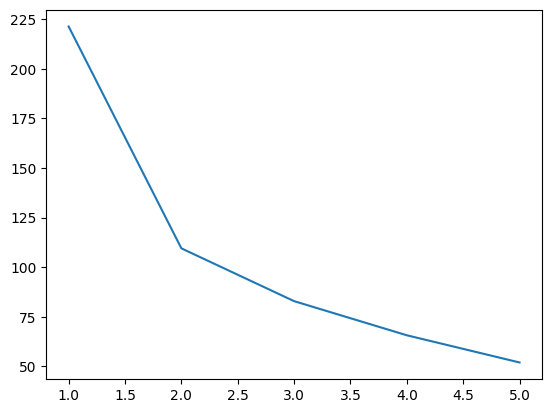

In [8]:
plt.plot(list(range(1,epochSize+1)), losses)

## Task: Create a function that evaluates trained model on the training dataset

* Compute the overall accuracy of the training set. Note that you need a call to model.eval() - this sets the model into evaluation mode and supresses non-training things (gradients, and things such as dropout being applied/computed).

In [11]:
def compute_accuracy(data_loader):
  total = correct = 0
  model.eval() # sets the model in evaluation mode 
  for input_batch, target_batch in data_loader: #data_loader can take train or test dataset
    predict_batch = model(input_batch)     
    _, predicted = torch.max(predict_batch.data, 1)
    total += target_batch.size(0)
    correct += (predicted == target_batch).sum().item()
  print(f'Accuracy of the network on images: {100 * correct / total}')
  print(f'number of evaluated data: {total}')
  print(f'number of wrongly predicted label: {total - correct}')



## 11.Task: Evaluation of trained model on test data

* Compute the overall accuracy of the test set. Note that you need a call to model.eval() - this sets the model into evaluation mode and supresses non-training things (gradients, and things such as dropout being applied/computed).

In [13]:
compute_accuracy(test_loader)
compute_accuracy(train_loader)

Accuracy of the network on images: 96.76
number of evaluated data: 10000
number of wrongly predicted label: 324
Accuracy of the network on images: 97.295
number of evaluated data: 60000
number of wrongly predicted label: 1623
